### Basic imports

In [1]:
import torch 
import numpy as np
import pandas as pd
from copy import deepcopy
import random
from torch.utils.data import DataLoader, Dataset
from torch import nn
from math import log
from torch.optim import Adam
from torch.nn import BCELoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
!pip show torch

Name: torch
Version: 2.3.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-nccl-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: flash-attn, lightning-thunder, speechbrain, torch-tensorrt, torchaudio, torchdata, torchtext, torchvision, transformer-engine


### Hyperparameters

In [2]:
num_negative_samples = 4   #Since the matrix is sparse, for every interaction we add a few numbers of the negative samples
num_epochs = 40
batch_size = 256
factors = [8]

### Data processing

In [3]:
users_raw = pd.read_csv("data/ml-1m/users.csv")
movies_raw = pd.read_csv("data/ml-1m/movies.csv")
num_user = users_raw['userId'].count()
num_item = movies_raw['itemId'].count()
print(num_item)
print(num_user)
#later these two will decide the dimension of embedding vectors

3706
6040


In [4]:
def get_implict_feedback(ratings):
    '''Compared to explict feedback, implict feedback take all ratings as 1(whether users like this item)'''
    assert 'rating' in ratings.columns
    
    ratings = deepcopy(ratings)
    ratings = ratings[ratings['rating'] > 0]
    ratings['rating'].apply(lambda x : 1.0)


ratings_raw = pd.read_csv("data/ml-1m/ratings.csv")
ratings = ratings_raw.drop(['origin_uid', 'origin_iid'], axis=1)
users = set(ratings['userId'].unique())
items = set(ratings['itemId'].unique())
#Above code get the unique pool of items and users


interact_status = ratings.groupby('userId')['itemId'].apply(set).reset_index().rename(
            columns={'itemId': 'interacted_items'})

interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: items - x)
#interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, 99))
#interact_status['_items'] = interact_status['interacted_items'].apply(lambda x: item_pool - x)

# 'interacted_items' notes the list of implict feedback, while 'negative_items' notes the the list of the rest of the items.


In [5]:
interact_status['len_of_inter'] = interact_status['interacted_items'].apply(lambda x : len(x))
interact_status['len_of_neg'] = interact_status['negative_items'].apply(lambda x : len(x))
#print(interact_status['lenOf'].min())
interact_status.head(10)
#interact_status[interact_status['lenOf'] == 1392]

,userId,interacted_items,negative_items,len_of_inter,len_of_neg
0,0,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","{53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 6...",53,3653
1,1,"{0, 18, 20, 42, 47, 48, 52, 53, 54, 55, 56, 57...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",129,3577
2,2,"{128, 4, 5, 22, 166, 168, 41, 44, 175, 176, 17...","{0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",51,3655
3,3,"{139, 26, 156, 43, 44, 48, 63, 64, 208, 209, 2...","{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",21,3685
4,4,"{3, 4, 9, 18, 27, 38, 39, 43, 48, 51, 59, 62, ...","{0, 1, 2, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, ...",198,3508
5,5,"{385, 386, 387, 388, 389, 390, 391, 392, 393, ...","{0, 1, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 1...",71,3635
6,6,"{132, 264, 148, 22, 151, 406, 150, 156, 430, 4...","{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",31,3675
7,7,"{512, 513, 18, 23, 27, 31, 36, 39, 40, 43, 48,...","{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",139,3567
8,8,"{514, 515, 516, 517, 518, 519, 4, 520, 521, 52...","{0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",106,3600
9,9,"{2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","{0, 1, 16, 18, 24, 28, 31, 34, 35, 36, 42, 43,...",401,3305


In [6]:
users_list, items_list, ratings_list = [], [], []
test_users_list, test_items_list = [],[]
test_users_negs, test_items_negs = [],[]

for row in interact_status.itertuples():
    
    pos_pool = set(row.interacted_items)
    neg_pool = set(row.negative_items)
    user_ = row.userId
    #First we handle test set data: one pos sample corresponds 99 neg samples
    test_item_pos = random.sample(pos_pool,1)
    test_item_neg = random.sample(neg_pool,99)
    test_users_list.append(int(user_))
    test_items_list.append(test_item_pos[0])
    #test_ratings_list.append(1.0)
    
    test_users_negs.append(int(user_))
    test_items_negs.append(list(map(int,test_item_neg)))#test_items_negs里面包含了多个长度为99的一元数组
    #for i in range(99):
         #test_items_negs.append(int(test_item_neg[i]))
         #test_ratings_list.append(float(0))
    #Secondly, handle the training set
    pos_pool = pos_pool - set(test_item_pos)
    neg_pool = neg_pool - set(test_item_neg)
    
    for pos_ in pos_pool:
         users_list.append(int(user_))
         items_list.append(int(pos_))
         ratings_list.append(1.0)
         if num_negative_samples > len(neg_pool):
              break
         neg_sample = random.sample(neg_pool,num_negative_samples)
         neg_pool = neg_pool - set(neg_sample)
         for neg_ in neg_sample:
              users_list.append(int(user_))
              items_list.append(int(neg_))
              ratings_list.append(float(0))
              


/tmp/ipykernel_15766/3808136817.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  test_item_pos = random.sample(pos_pool,1)
/tmp/ipykernel_15766/3808136817.py:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  test_item_neg = random.sample(neg_pool,99)
/tmp/ipykernel_15766/3808136817.py:32: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  neg_sample = random.sample(neg_pool,num_negative_samples)


In [7]:
print(len(ratings_list))
print(len(test_items_negs))

assert len(users_list) == len(items_list) == len(ratings_list)
assert len(test_items_list) == num_user
assert len(test_users_list) == num_user
assert len(test_users_negs) == num_user
assert len(test_users_negs) == num_user



4757617
6040


In [8]:
class TrainDataset(Dataset):
    def __init__(self, user_tensor, item_tensor, rating_tensor):
        self.user_tensor = user_tensor
        self.item_tensor = item_tensor
        self.rating_tensor = rating_tensor

    def __getitem__(self, index):
        return self.user_tensor[index], self.item_tensor[index], self.rating_tensor[index]

    def __len__(self):
        return self.user_tensor.size(0)


Train_dataset = TrainDataset(user_tensor=torch.LongTensor(users_list),
                             item_tensor=torch.LongTensor(items_list),
                             rating_tensor=torch.FloatTensor(ratings_list))


Train_dataloader = DataLoader(Train_dataset,batch_size=batch_size,shuffle=True,num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Models
---
Three models are defined.

In [10]:
class GMF(nn.Module):
    def __init__(self,num_user,num_item,latent_dim):
        super(GMF, self).__init__()
        self.num_users = num_user
        self.num_items = num_item
        self.latent_dim = latent_dim
        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)
        self.affine_output = nn.Linear(in_features=self.latent_dim, out_features=1)
        self.logistic = nn.Sigmoid()
        
 
    def forward(self, user_ids, item_ids):
        user_embedding = self.embedding_user(user_ids)
        item_embedding = self.embedding_item(item_ids)
        elementwise_product = torch.mul(user_embedding, item_embedding)
        logits = self.affine_output(elementwise_product)#逐个元素的乘积
        rating = self.logistic(logits) #映射到概率
        return rating

In [11]:
class MLP(nn.Module):
    def __init__(self,num_user,num_item,layers):
        super(MLP, self).__init__()
        self.num_users = num_user
        self.num_items = num_item
        
        #layers 定义了一系列的线性层输入输出维度，第一个元素的1/2便是latent vector的维度（因为要把latent vector 拼接起来，即为layer[0]）
        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=layers[0] // 2)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=layers[0] // 2)
        
        self.fc_layers  = torch.nn.ModuleList()
        for i in range(1, len(layers)):
            self.fc_layers.append(nn.Linear(layers[i - 1], layers[i]))
        self.affine_output = nn.Linear(in_features=layers[-1], out_features=1)
        self.relu = nn.ReLU()#activation function between linear layers
        self.logistic = nn.Sigmoid()
        
 
    def forward(self, user_ids, item_ids):
        user_embedding = self.embedding_user(user_ids)
        item_embedding = self.embedding_item(item_ids)
        vec = torch.cat([user_embedding,item_embedding],dim=-1) #这里将latent vector连接起来
        for i,layer in enumerate(self.fc_layers):
            vec = self.relu(layer(vec))

        logits = self.affine_output(vec)#逐个元素的乘积
        rating = self.logistic(logits) #映射到概率
        return rating


In [12]:
class NeuMF(nn.Module):
    '''将mlp和GMF的最后一层的结果拼起来'''
    def __init__(self,num_user,num_item,latent_dim,layers):
        super(NeuMF, self).__init__()
        self.num_users = num_user
        self.num_items = num_item
        self.latent_dim = latent_dim

        self.embedding_user_gmf = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item_gmf = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)
        self.embedding_user_mlp = nn.Embedding(num_embeddings=self.num_users, embedding_dim=layers[0] // 2)
        self.embedding_item_mlp = nn.Embedding(num_embeddings=self.num_items, embedding_dim=layers[0] // 2)

        self.fc_layers = nn.ModuleList()
        for i in range(1, len(layers)):
            self.fc_layers.append(nn.Linear(layers[i - 1], layers[i]))

        self.output_layer = nn.Linear(in_features=(latent_dim + layers[-1]), out_features=1)
        self.relu = nn.ReLU()
        self.logistic = nn.Sigmoid()
    def forward(self,user_ids,item_ids):
        user_embedding_gmf = self.embedding_user_gmf(user_ids)
        item_embedding_gmf = self.embedding_item_gmf(item_ids)
        user_embedding_mlp = self.embedding_user_mlp(user_ids)
        item_embedding_mlp = self.embedding_item_mlp(item_ids)

        elementwise_product = torch.mul(user_embedding_gmf,item_embedding_gmf)
        vec = torch.cat([user_embedding_mlp,item_embedding_mlp],dim=-1)
        for i,layer in enumerate(self.fc_layers):
            vec = self.relu(layer(vec)) 
        vector = torch.cat([elementwise_product,vec],dim=-1)
        logits = self.output_layer(vector)
        return self.logistic(logits)

### Training & evaluation methods

In [13]:
def train(model, data, optimizer, criterion,sche):
    #model.to(device)
    model.train()
    total_loss = 0
    for user_ids, item_ids, ratings in data:
        optimizer.zero_grad()
        outputs = model(user_ids.to(device), item_ids.to(device))
        loss = criterion(outputs.squeeze(), ratings.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    sche.step(total_loss)
    return total_loss / len(data)


In [14]:
def evaluate(model, test_user,test_item,neg_item, K):
    model.eval()
    hits = []
    ndcgs = [] 

    with torch.no_grad():
        for i in range(len(test_user)):
            
            The_user = test_user[i]
            The_item = test_item[i]
            items = neg_item[i][:]  # 拷贝 neg_item[i] 的内容
            items.append(test_item[i])  # 将 test_item[i] 添加到拷贝后的列表
            
            users_vec = torch.full((len(items),), The_user, dtype=torch.long).to(device)
            item_vec = torch.tensor(items, dtype=torch.long).to(device)     

            prediction = model(users_vec, item_vec)
            values, indices = torch.topk(prediction, K, dim=0,largest=True,sorted=True)
            ranklist = [items[index] for index in indices]  

            hr = getHitRatio(ranklist, The_item)
            ndcg = getNDCG(ranklist, The_item)
            hits.append(hr)
            ndcgs.append(ndcg)

    return np.mean(hits), np.mean(ndcgs)

def getHitRatio(ranklist, target):
    if target in ranklist:
        return 1
    return 0

def getNDCG(ranklist, target):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == target:
            return log(2) / log(i + 2) 
    return 0

### Loss function

In [15]:
criterion = BCELoss()

### Uitlities

In [16]:
def gen_results(loss,hr,ndcg,name):
    Epochs = [x for x in range(1,num_epochs + 1)]
    results = pd.DataFrame({'Epoch':Epochs , 'Loss':loss, 'HR@10':hr , 'NDCG@10':ndcg})
    results.to_csv(name + '.csv' , index=False,header=True)


def get_layers(x):
    layers = deepcopy(factors)
    factor = deepcopy(factors[0])

    for i in range(x):

        factor = factor * 2
        layers.append(factor)
    layers.reverse()
    return layers

### Training 

In [17]:
gmf = GMF(num_user=num_user,num_item=num_item,latent_dim=factors[0])
gmf.to(device=device)
optimizer = Adam(gmf.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
gmf_loss = []
gmf_hr = []
gmf_ndcg = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1} begins ')
    loss = train(model=gmf,data=Train_dataloader,optimizer=optimizer,criterion=criterion,sche=scheduler)
    hr, ndcg = evaluate(gmf, test_user=test_users_list, test_item=test_items_list,neg_item=test_items_negs,K=10)
    gmf_loss.append(loss)
    gmf_hr.append(hr)
    gmf_ndcg.append(ndcg)
    print(f'Epoch: {epoch+1}/50 ; loss: {loss:.4f} ; HR@10: {hr:.4f} ; NDCG@10: {ndcg:.4f}')

Epoch 1 begins 


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1/50 ; loss: 0.5075 ; HR@10: 0.1040 ; NDCG@10: 0.0485
Epoch 2 begins 
Epoch: 2/50 ; loss: 0.4784 ; HR@10: 0.4179 ; NDCG@10: 0.2318
Epoch 3 begins 
Epoch: 3/50 ; loss: 0.3715 ; HR@10: 0.5323 ; NDCG@10: 0.3161
Epoch 4 begins 
Epoch: 4/50 ; loss: 0.3506 ; HR@10: 0.5528 ; NDCG@10: 0.3291
Epoch 5 begins 
Epoch: 5/50 ; loss: 0.3437 ; HR@10: 0.5755 ; NDCG@10: 0.3427
Epoch 6 begins 
Epoch: 6/50 ; loss: 0.3332 ; HR@10: 0.5995 ; NDCG@10: 0.3589
Epoch 7 begins 
Epoch: 7/50 ; loss: 0.3185 ; HR@10: 0.6333 ; NDCG@10: 0.3832
Epoch 8 begins 
Epoch: 8/50 ; loss: 0.3063 ; HR@10: 0.6584 ; NDCG@10: 0.4047
Epoch 9 begins 
Epoch: 9/50 ; loss: 0.2963 ; HR@10: 0.6803 ; NDCG@10: 0.4235
Epoch 10 begins 
Epoch: 10/50 ; loss: 0.2883 ; HR@10: 0.6998 ; NDCG@10: 0.4408
Epoch 11 begins 
Epoch: 11/50 ; loss: 0.2825 ; HR@10: 0.7118 ; NDCG@10: 0.4517
Epoch 12 begins 
Epoch: 12/50 ; loss: 0.2782 ; HR@10: 0.7200 ; NDCG@10: 0.4605
Epoch 13 begins 
Epoch: 13/50 ; loss: 0.2750 ; HR@10: 0.7275 ; NDCG@10: 0.4690
Epoch 1

In [18]:
gen_results(gmf_loss,gmf_hr,gmf_ndcg,'GMF')

In [19]:
layers = get_layers(0)
mlp_0 = MLP(num_user=num_user,num_item=num_item,layers=layers)
mlp_0.to(device=device)
optimizer = Adam(mlp_0.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
mlp_0_loss = []
mlp_0_hr = []
mlp_0_ndcg = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1} begins')
    loss = train(model=mlp_0,data=Train_dataloader,optimizer=optimizer,criterion=criterion,sche=scheduler)
    hr, ndcg = evaluate(mlp_0, test_user=test_users_list, test_item=test_items_list,neg_item=test_items_negs,K=10)
    mlp_0_loss.append(loss)
    mlp_0_hr.append(hr)
    mlp_0_ndcg.append(ndcg)
    print(f'Epoch: {epoch+1}/50 ; loss: {loss:.4f} ; HR@10: {hr:.4f} ; NDCG@10: {ndcg:.4f}')
    
gen_results(mlp_0_loss,mlp_0_hr,mlp_0_ndcg,'MLP_0')

Epoch 1 begins


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1/50 ; loss: 0.3856 ; HR@10: 0.5503 ; NDCG@10: 0.3262
Epoch 2 begins
Epoch: 2/50 ; loss: 0.3548 ; HR@10: 0.5510 ; NDCG@10: 0.3280
Epoch 3 begins
Epoch: 3/50 ; loss: 0.3539 ; HR@10: 0.5558 ; NDCG@10: 0.3286
Epoch 4 begins
Epoch: 4/50 ; loss: 0.3535 ; HR@10: 0.5498 ; NDCG@10: 0.3275
Epoch 5 begins
Epoch: 5/50 ; loss: 0.3533 ; HR@10: 0.5520 ; NDCG@10: 0.3287
Epoch 6 begins
Epoch: 6/50 ; loss: 0.3531 ; HR@10: 0.5538 ; NDCG@10: 0.3286
Epoch 7 begins
Epoch: 7/50 ; loss: 0.3530 ; HR@10: 0.5541 ; NDCG@10: 0.3288
Epoch 8 begins
Epoch: 8/50 ; loss: 0.3530 ; HR@10: 0.5528 ; NDCG@10: 0.3290
Epoch 9 begins
Epoch: 9/50 ; loss: 0.3529 ; HR@10: 0.5543 ; NDCG@10: 0.3294
Epoch 10 begins
Epoch: 10/50 ; loss: 0.3529 ; HR@10: 0.5560 ; NDCG@10: 0.3296
Epoch 11 begins
Epoch: 11/50 ; loss: 0.3529 ; HR@10: 0.5545 ; NDCG@10: 0.3290
Epoch 12 begins
Epoch: 12/50 ; loss: 0.3528 ; HR@10: 0.5543 ; NDCG@10: 0.3296
Epoch 13 begins
Epoch: 13/50 ; loss: 0.3528 ; HR@10: 0.5535 ; NDCG@10: 0.3293
Epoch 14 begins
Epo

In [20]:
layers = get_layers(1)

mlp_1 = MLP(num_user=num_user,num_item=num_item,layers=layers)
mlp_1.to(device=device)
optimizer = Adam(mlp_1.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
mlp_1_loss = []
mlp_1_hr = []
mlp_1_ndcg = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1} begins')
    loss = train(model=mlp_1,data=Train_dataloader,optimizer=optimizer,criterion=criterion,sche=scheduler)
    hr, ndcg = evaluate(mlp_1, test_user=test_users_list, test_item=test_items_list,neg_item=test_items_negs,K=10)
    mlp_1_loss.append(loss)
    mlp_1_hr.append(hr)
    mlp_1_ndcg.append(ndcg)
    print(f'Epoch: {epoch+1}/50 ; loss: {loss:.4f} ; HR@10: {hr:.4f} ; NDCG@10: {ndcg:.4f}')
    
gen_results(mlp_1_loss,mlp_1_hr,mlp_1_ndcg,'MLP_1')

Epoch 1 begins


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1/50 ; loss: 0.3753 ; HR@10: 0.5502 ; NDCG@10: 0.3247
Epoch 2 begins
Epoch: 2/50 ; loss: 0.3553 ; HR@10: 0.5555 ; NDCG@10: 0.3271
Epoch 3 begins
Epoch: 3/50 ; loss: 0.3536 ; HR@10: 0.5553 ; NDCG@10: 0.3300
Epoch 4 begins
Epoch: 4/50 ; loss: 0.3510 ; HR@10: 0.5540 ; NDCG@10: 0.3310
Epoch 5 begins
Epoch: 5/50 ; loss: 0.3486 ; HR@10: 0.5558 ; NDCG@10: 0.3321
Epoch 6 begins
Epoch: 6/50 ; loss: 0.3468 ; HR@10: 0.5627 ; NDCG@10: 0.3345
Epoch 7 begins
Epoch: 7/50 ; loss: 0.3452 ; HR@10: 0.5656 ; NDCG@10: 0.3383
Epoch 8 begins
Epoch: 8/50 ; loss: 0.3434 ; HR@10: 0.5717 ; NDCG@10: 0.3427
Epoch 9 begins
Epoch: 9/50 ; loss: 0.3414 ; HR@10: 0.5775 ; NDCG@10: 0.3465
Epoch 10 begins
Epoch: 10/50 ; loss: 0.3391 ; HR@10: 0.5887 ; NDCG@10: 0.3543
Epoch 11 begins
Epoch: 11/50 ; loss: 0.3367 ; HR@10: 0.5919 ; NDCG@10: 0.3575
Epoch 12 begins
Epoch: 12/50 ; loss: 0.3345 ; HR@10: 0.5957 ; NDCG@10: 0.3619
Epoch 13 begins
Epoch: 13/50 ; loss: 0.3325 ; HR@10: 0.6050 ; NDCG@10: 0.3666
Epoch 14 begins
Epo

In [21]:
layers = get_layers(2)

mlp_2 = MLP(num_user=num_user,num_item=num_item,layers=layers)
mlp_2.to(device=device)
optimizer = Adam(mlp_2.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
mlp_2_loss = []
mlp_2_hr = []
mlp_2_ndcg = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1} begins')
    loss = train(model=mlp_2,data=Train_dataloader,optimizer=optimizer,criterion=criterion,sche=scheduler)
    hr, ndcg = evaluate(mlp_2, test_user=test_users_list, test_item=test_items_list,neg_item=test_items_negs,K=10)
    mlp_2_loss.append(loss)
    mlp_2_hr.append(hr)
    mlp_2_ndcg.append(ndcg)
    print(f'Epoch: {epoch+1}/50 ; loss: {loss:.4f} ; HR@10: {hr:.4f} ; NDCG@10: {ndcg:.4f}')
    
gen_results(mlp_2_loss,mlp_2_hr,mlp_2_ndcg,'MLP_2')

Epoch 1 begins


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1/50 ; loss: 0.3703 ; HR@10: 0.5495 ; NDCG@10: 0.3207
Epoch 2 begins
Epoch: 2/50 ; loss: 0.3546 ; HR@10: 0.5498 ; NDCG@10: 0.3231
Epoch 3 begins
Epoch: 3/50 ; loss: 0.3505 ; HR@10: 0.5541 ; NDCG@10: 0.3245
Epoch 4 begins
Epoch: 4/50 ; loss: 0.3475 ; HR@10: 0.5621 ; NDCG@10: 0.3319
Epoch 5 begins
Epoch: 5/50 ; loss: 0.3439 ; HR@10: 0.5715 ; NDCG@10: 0.3414
Epoch 6 begins
Epoch: 6/50 ; loss: 0.3378 ; HR@10: 0.5901 ; NDCG@10: 0.3537
Epoch 7 begins
Epoch: 7/50 ; loss: 0.3283 ; HR@10: 0.6156 ; NDCG@10: 0.3705
Epoch 8 begins
Epoch: 8/50 ; loss: 0.3189 ; HR@10: 0.6315 ; NDCG@10: 0.3834
Epoch 9 begins
Epoch: 9/50 ; loss: 0.3132 ; HR@10: 0.6478 ; NDCG@10: 0.3955
Epoch 10 begins
Epoch: 10/50 ; loss: 0.3090 ; HR@10: 0.6586 ; NDCG@10: 0.4022
Epoch 11 begins
Epoch: 11/50 ; loss: 0.3050 ; HR@10: 0.6709 ; NDCG@10: 0.4113
Epoch 12 begins
Epoch: 12/50 ; loss: 0.3010 ; HR@10: 0.6768 ; NDCG@10: 0.4187
Epoch 13 begins
Epoch: 13/50 ; loss: 0.2975 ; HR@10: 0.6879 ; NDCG@10: 0.4269
Epoch 14 begins
Epo

In [22]:
layers = get_layers(3)

mlp_3 = MLP(num_user=num_user,num_item=num_item,layers=layers)
mlp_3.to(device=device)
optimizer = Adam(mlp_3.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
mlp_3_loss = []
mlp_3_hr = []
mlp_3_ndcg = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1} begins')
    loss = train(model=mlp_3,data=Train_dataloader,optimizer=optimizer,criterion=criterion,sche=scheduler)
    hr, ndcg = evaluate(mlp_3, test_user=test_users_list, test_item=test_items_list,neg_item=test_items_negs,K=10)
    mlp_3_loss.append(loss)
    mlp_3_hr.append(hr)
    mlp_3_ndcg.append(ndcg)
    print(f'Epoch: {epoch+1}/50 ; loss: {loss:.4f} ; HR@10: {hr:.4f} ; NDCG@10: {ndcg:.4f}')
    
gen_results(mlp_3_loss,mlp_3_hr,mlp_3_ndcg,'MLP_3')

Epoch 1 begins


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1/50 ; loss: 0.3652 ; HR@10: 0.5517 ; NDCG@10: 0.3258
Epoch 2 begins
Epoch: 2/50 ; loss: 0.3501 ; HR@10: 0.5541 ; NDCG@10: 0.3297
Epoch 3 begins
Epoch: 3/50 ; loss: 0.3447 ; HR@10: 0.5868 ; NDCG@10: 0.3493
Epoch 4 begins
Epoch: 4/50 ; loss: 0.3315 ; HR@10: 0.6055 ; NDCG@10: 0.3662
Epoch 5 begins
Epoch: 5/50 ; loss: 0.3209 ; HR@10: 0.6339 ; NDCG@10: 0.3855
Epoch 6 begins
Epoch: 6/50 ; loss: 0.3117 ; HR@10: 0.6515 ; NDCG@10: 0.4029
Epoch 7 begins
Epoch: 7/50 ; loss: 0.3039 ; HR@10: 0.6671 ; NDCG@10: 0.4147
Epoch 8 begins
Epoch: 8/50 ; loss: 0.2980 ; HR@10: 0.6871 ; NDCG@10: 0.4285
Epoch 9 begins
Epoch: 9/50 ; loss: 0.2938 ; HR@10: 0.6940 ; NDCG@10: 0.4350
Epoch 10 begins
Epoch: 10/50 ; loss: 0.2905 ; HR@10: 0.7028 ; NDCG@10: 0.4410
Epoch 11 begins
Epoch: 11/50 ; loss: 0.2875 ; HR@10: 0.7093 ; NDCG@10: 0.4495
Epoch 12 begins
Epoch: 12/50 ; loss: 0.2847 ; HR@10: 0.7118 ; NDCG@10: 0.4506
Epoch 13 begins
Epoch: 13/50 ; loss: 0.2819 ; HR@10: 0.7164 ; NDCG@10: 0.4562
Epoch 14 begins
Epo

In [23]:
layers = get_layers(4)

mlp_4 = MLP(num_user=num_user,num_item=num_item,layers=layers)
mlp_4.to(device=device)
optimizer = Adam(mlp_4.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
mlp_4_loss = []
mlp_4_hr = []
mlp_4_ndcg = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1} begins')
    loss = train(model=mlp_4,data=Train_dataloader,optimizer=optimizer,criterion=criterion,sche=scheduler)
    hr, ndcg = evaluate(mlp_4, test_user=test_users_list, test_item=test_items_list,neg_item=test_items_negs,K=10)
    mlp_4_loss.append(loss)
    mlp_4_hr.append(hr)
    mlp_4_ndcg.append(ndcg)
    print(f'Epoch: {epoch+1}/50 ; loss: {loss:.4f} ; HR@10: {hr:.4f} ; NDCG@10: {ndcg:.4f}')
    
gen_results(mlp_4_loss,mlp_4_hr,mlp_4_ndcg,'MLP_4')

Epoch 1 begins


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1/50 ; loss: 0.3620 ; HR@10: 0.5550 ; NDCG@10: 0.3284
Epoch 2 begins
Epoch: 2/50 ; loss: 0.3467 ; HR@10: 0.5778 ; NDCG@10: 0.3466
Epoch 3 begins
Epoch: 3/50 ; loss: 0.3282 ; HR@10: 0.6200 ; NDCG@10: 0.3769
Epoch 4 begins
Epoch: 4/50 ; loss: 0.3141 ; HR@10: 0.6548 ; NDCG@10: 0.4048
Epoch 5 begins
Epoch: 5/50 ; loss: 0.3021 ; HR@10: 0.6853 ; NDCG@10: 0.4268
Epoch 6 begins
Epoch: 6/50 ; loss: 0.2932 ; HR@10: 0.7002 ; NDCG@10: 0.4410
Epoch 7 begins
Epoch: 7/50 ; loss: 0.2861 ; HR@10: 0.7103 ; NDCG@10: 0.4492
Epoch 8 begins
Epoch: 8/50 ; loss: 0.2800 ; HR@10: 0.7207 ; NDCG@10: 0.4585
Epoch 9 begins
Epoch: 9/50 ; loss: 0.2747 ; HR@10: 0.7280 ; NDCG@10: 0.4681
Epoch 10 begins
Epoch: 10/50 ; loss: 0.2699 ; HR@10: 0.7326 ; NDCG@10: 0.4733
Epoch 11 begins
Epoch: 11/50 ; loss: 0.2656 ; HR@10: 0.7391 ; NDCG@10: 0.4791
Epoch 12 begins
Epoch: 12/50 ; loss: 0.2617 ; HR@10: 0.7425 ; NDCG@10: 0.4826
Epoch 13 begins
Epoch: 13/50 ; loss: 0.2580 ; HR@10: 0.7513 ; NDCG@10: 0.4883
Epoch 14 begins
Epo

In [24]:
layers = get_layers(3)
Neu = NeuMF(num_user=num_user,num_item=num_item,latent_dim=factors[0],layers=layers)
Neu.to(device=device)
optimizer = Adam(Neu.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
Neu_loss = []
Neu_hr = []
Neu_ndcg = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1} begins')
    loss = train(model=Neu,data=Train_dataloader,optimizer=optimizer,criterion=criterion,sche=scheduler)
    hr, ndcg = evaluate(Neu, test_user=test_users_list, test_item=test_items_list,neg_item=test_items_negs,K=10)
    Neu_loss.append(loss)
    Neu_hr.append(hr)
    Neu_ndcg.append(ndcg)
    print(f'Epoch: {epoch+1}/50 ; loss: {loss:.4f} ; HR@10: {hr:.4f} ; NDCG@10: {ndcg:.4f}')

gen_results(Neu_loss,Neu_hr,Neu_ndcg,'Neu')

Epoch 1 begins


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1/50 ; loss: 0.3654 ; HR@10: 0.5470 ; NDCG@10: 0.3248
Epoch 2 begins
Epoch: 2/50 ; loss: 0.3499 ; HR@10: 0.5520 ; NDCG@10: 0.3274
Epoch 3 begins
Epoch: 3/50 ; loss: 0.3444 ; HR@10: 0.5833 ; NDCG@10: 0.3476
Epoch 4 begins
Epoch: 4/50 ; loss: 0.3317 ; HR@10: 0.6088 ; NDCG@10: 0.3680
Epoch 5 begins
Epoch: 5/50 ; loss: 0.3223 ; HR@10: 0.6207 ; NDCG@10: 0.3775
Epoch 6 begins
Epoch: 6/50 ; loss: 0.3151 ; HR@10: 0.6374 ; NDCG@10: 0.3875
Epoch 7 begins
Epoch: 7/50 ; loss: 0.3049 ; HR@10: 0.6636 ; NDCG@10: 0.4058
Epoch 8 begins
Epoch: 8/50 ; loss: 0.2919 ; HR@10: 0.6892 ; NDCG@10: 0.4270
Epoch 9 begins
Epoch: 9/50 ; loss: 0.2804 ; HR@10: 0.7103 ; NDCG@10: 0.4466
Epoch 10 begins
Epoch: 10/50 ; loss: 0.2719 ; HR@10: 0.7227 ; NDCG@10: 0.4586
Epoch 11 begins
Epoch: 11/50 ; loss: 0.2656 ; HR@10: 0.7331 ; NDCG@10: 0.4695
Epoch 12 begins
Epoch: 12/50 ; loss: 0.2607 ; HR@10: 0.7424 ; NDCG@10: 0.4786
Epoch 13 begins
Epoch: 13/50 ; loss: 0.2568 ; HR@10: 0.7459 ; NDCG@10: 0.4824
Epoch 14 begins
Epo

### Visualizations

In [44]:
gmf_info = pd.read_csv('GMF.csv')
neu_info = pd.read_csv('Neu.csv')
MLP4_info = pd.read_csv('MLP_4.csv')
MLP3_info = pd.read_csv('MLP_3.csv')
MLP2_info = pd.read_csv('MLP_2.csv')
MLP1_info = pd.read_csv('MLP_1.csv')
MLP0_info = pd.read_csv('MLP_0.csv')

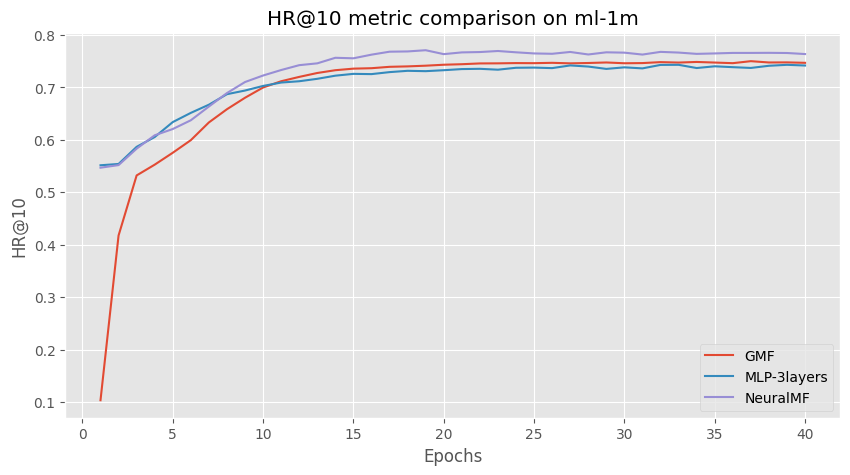

<Figure size 640x480 with 0 Axes>

In [49]:
plt.style.use('ggplot')
plt.figure(figsize=(10,5))   
plt.plot(list(gmf_info['Epoch']),gmf_info['HR@10'],label='GMF')
plt.plot(list(gmf_info['Epoch']),MLP3_info['HR@10'],label='MLP-3layers')
plt.plot(list(gmf_info['Epoch']),neu_info['HR@10'],label='NeuralMF')
plt.title('HR@10 metric comparison on ml-1m')
plt.ylabel('HR@10')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()
plt.savefig('HR@10.png')

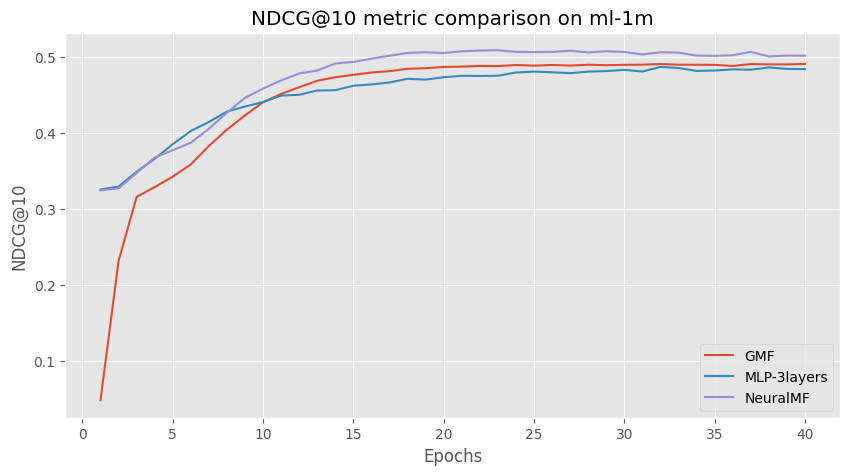

<Figure size 640x480 with 0 Axes>

In [50]:
plt.style.use('ggplot')
plt.figure(figsize=(10,5))   
plt.plot(list(gmf_info['Epoch']),gmf_info['NDCG@10'],label='GMF')
plt.plot(list(gmf_info['Epoch']),MLP3_info['NDCG@10'],label='MLP-3layers')
plt.plot(list(gmf_info['Epoch']),neu_info['NDCG@10'],label='NeuralMF')
plt.title('NDCG@10 metric comparison on ml-1m')
plt.ylabel('NDCG@10')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()
plt.savefig('NDCG@10.png')

In [51]:
results_dict = {
    'GMF':[max(list(gmf_info['HR@10'])),max(list(gmf_info['NDCG@10']))],
    'MLP-0':[max(list(MLP0_info['HR@10'])),max(list(MLP0_info['NDCG@10']))] ,
    'MLP-1':[max(list(MLP1_info['HR@10'])),max(list(MLP1_info['NDCG@10']))] ,
    'MLP-2':[max(list(MLP2_info['HR@10'])),max(list(MLP2_info['NDCG@10']))] ,
    'MLP-3':[max(list(MLP3_info['HR@10'])),max(list(MLP3_info['NDCG@10']))] ,
    'MLP-4':[max(list(MLP4_info['HR@10'])),max(list(MLP4_info['NDCG@10']))] ,
    'NeuMF':[max(list(neu_info['HR@10'])),max(list(neu_info['NDCG@10']))] 
}

In [52]:
index = pd.Index(['HR@10', 'NDCG@10'], name='metric')  
results = pd.DataFrame(results_dict,index=index)

### Ablation study results

In [53]:
results

,GMF,MLP-0,MLP-1,MLP-2,MLP-3,MLP-4,NeuMF
metric,,,,,,,
HR@10,0.750000,0.555960,0.674503,0.729801,0.743046,0.757781,0.770861
NDCG@10,0.491107,0.329678,0.415787,0.469550,0.487267,0.496092,0.509181
